<a href="https://colab.research.google.com/github/siddhusam/Machine_Learning/blob/main/Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 1363s 9s/step - loss: 0.3661 - accuracy: 0.0891 - val_loss: 0.3570 - val_accuracy: 0.0920
Epoch 2/25
141/141 [==============================] - 60s 422ms/step - loss: 0.3161 - accuracy: 0.0891 - val_loss: 0.3128 - val_accuracy: 0.0920
Epoch 3/25
141/141 [==============================] - 61s 431ms/step - loss: 0.3096 - accuracy: 0.0891 - val_loss: 0.3436 - val_accuracy: 0.0920
Epoch 4/25
141/141 [==============================] - 61s 432ms/step - loss: 0.3115 - accuracy: 0.0891 - val_loss: 0.3207 - val_accuracy: 0.0920
Epoch 5/25
141/141 [==============================] - 61s 430ms/step - loss: 0.3053 - accuracy: 0.0891 - val_loss: 0.3409 - val_accuracy: 0.0920
Epoch 6/25
141/141 [==============================] - 61s 432ms/step - loss: 0.3103 - accuracy:

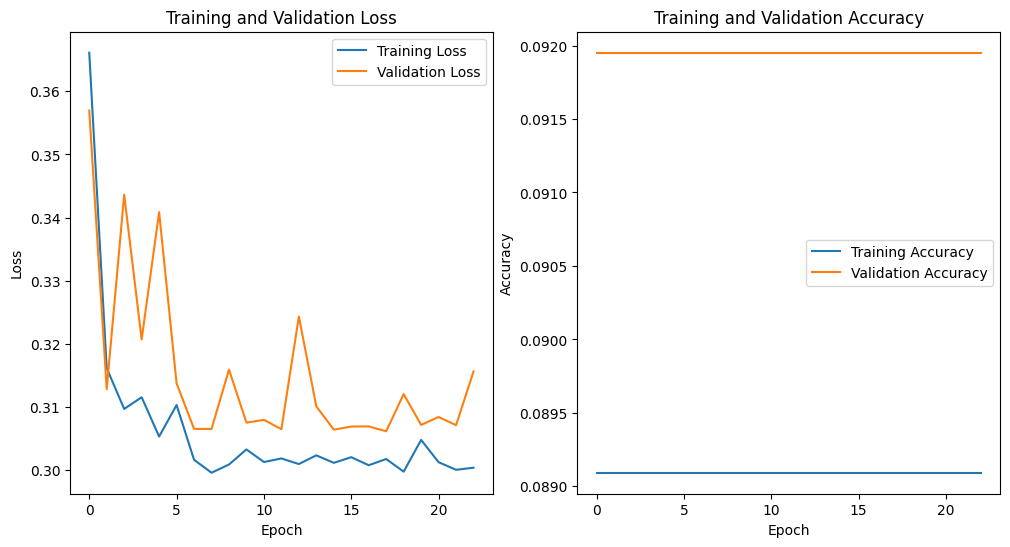

47/47 [==============================] - 349s 8s/step - loss: 0.3199 - accuracy: 0.0981
Test Loss: 0.31985631585121155
Test Accuracy: 0.09814757853746414


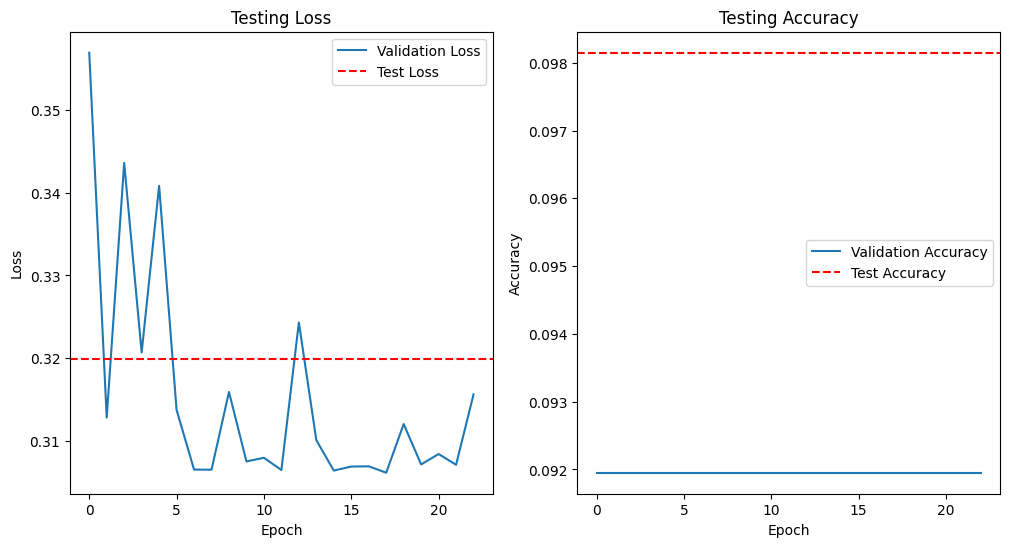

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/propeller'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(test_gen)
# Generate predictions on the test dataset
predictions_binary = (predictions > 0.5).astype(np.uint8)
test_masks_binary = []
for mask_path in test_masks:
    mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)  # Corrected masks_path
    mask = cv2.resize(mask, (256, 256))
    mask = (mask > 127).astype(np.uint8)
    test_masks_binary.append(mask)

test_masks_binary = np.array(test_masks_binary)

# Flatten predictions and ground truth masks
predictions_flattened = predictions_binary.flatten()
test_masks_flattened = test_masks_binary.flatten()

# Compute confusion matrix
min_length = min(len(predictions_flattened), len(test_masks_flattened))
predictions_flattened = predictions_flattened[:min_length]
test_masks_flattened = test_masks_flattened[:min_length]

# Compute confusion matrix
conf_matrix = confusion_matrix(test_masks_flattened, predictions_flattened)

print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(test_masks_flattened, predictions_flattened))

47/47 [==============================] - 14s 301ms/step
Confusion Matrix:
[[       0 22223029]
 [       0  2418507]]

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00  22223029
           1       0.10      1.00      0.18   2418507

    accuracy                           0.10  24641536
   macro avg       0.05      0.50      0.09  24641536
weighted avg       0.01      0.10      0.02  24641536



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mounted at /content/drive
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 692s 5s/step - loss: 0.1590 - accuracy: 0.0269 - val_loss: 0.1653 - val_accuracy: 0.0310
Epoch 2/25
141/141 [==============================] - 61s 429ms/step - loss: 0.1293 - accuracy: 0.0269 - val_loss: 0.1405 - val_accuracy: 0.0310
Epoch 3/25
141/141 [==============================] - 61s 434ms/step - loss: 0.1265 - accuracy: 0.0269 - val_loss: 0.1382 - val_accuracy: 0.0310
Epoch 4/25
141/141 [==============================] - 60s 425ms/step - loss: 0.1253 - accuracy: 0.0269 - val_loss: 0.1388 - val_accuracy: 0.0310
Epoch 5/25
141/141 [==============================] - 69s 486ms/step - loss: 0.1290 - accuracy: 0.0269 - val_loss: 0.1455 - val_accuracy: 0.0310
Epoch 6/25
141/141 [==============================] - 59s 416ms/step - loss: 0.1289 - accuracy: 0.0269 - val_loss: 0.1387 - val_accuracy: 0.0310
Epoch 7/25
141/141 [==============================] - 

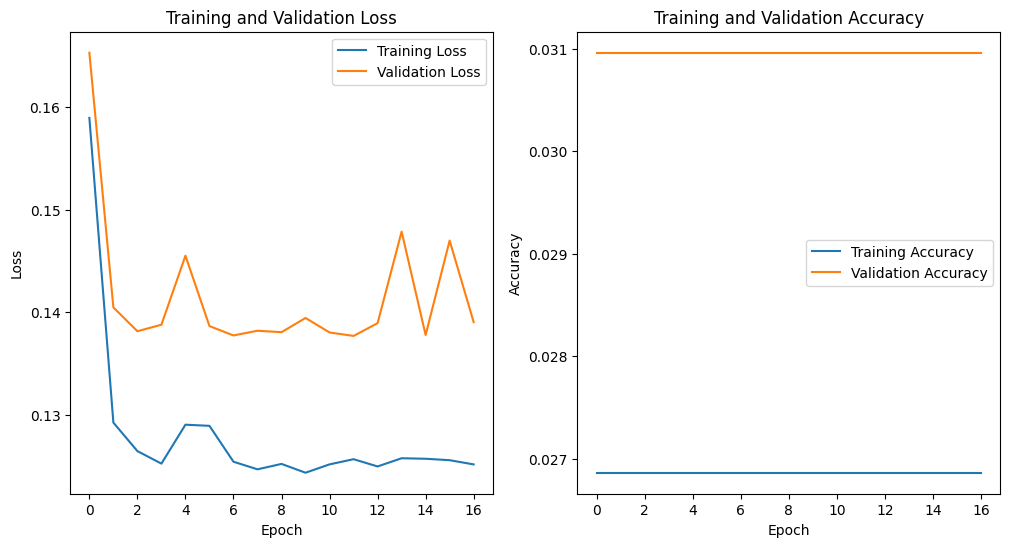

47/47 [==============================] - 144s 3s/step - loss: 0.1267 - accuracy: 0.0277
Test Loss: 0.12670007348060608
Test Accuracy: 0.027724124491214752


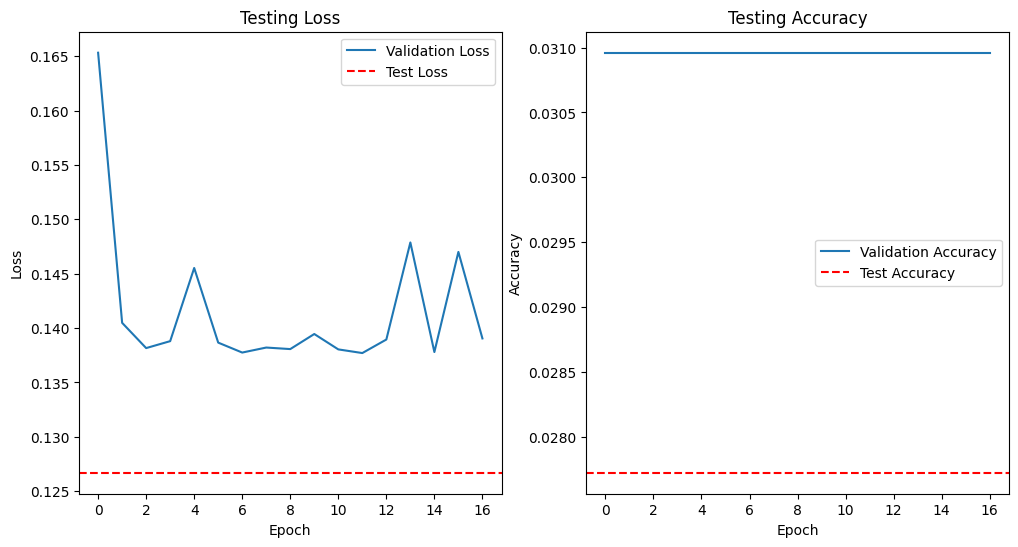

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/paint_peel'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(test_gen)
# Generate predictions on the test dataset
predictions_binary = (predictions > 0.5).astype(np.uint8)
test_masks_binary = []
for mask_path in test_masks:
    mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)  # Corrected masks_path
    mask = cv2.resize(mask, (256, 256))
    mask = (mask > 127).astype(np.uint8)
    test_masks_binary.append(mask)

test_masks_binary = np.array(test_masks_binary)

# Flatten predictions and ground truth masks
predictions_flattened = predictions_binary.flatten()
test_masks_flattened = test_masks_binary.flatten()

# Compute confusion matrix
min_length = min(len(predictions_flattened), len(test_masks_flattened))
predictions_flattened = predictions_flattened[:min_length]
test_masks_flattened = test_masks_flattened[:min_length]

# Compute confusion matrix
conf_matrix = confusion_matrix(test_masks_flattened, predictions_flattened)

print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(test_masks_flattened, predictions_flattened))

47/47 [==============================] - 11s 242ms/step
Confusion Matrix:
[[       0 24513342]
 [       0   128194]]

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00  24513342
           1       0.01      1.00      0.01    128194

    accuracy                           0.01  24641536
   macro avg       0.00      0.50      0.01  24641536
weighted avg       0.00      0.01      0.00  24641536



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 540s 4s/step - loss: 0.0836 - accuracy: 0.0073 - val_loss: 0.0445 - val_accuracy: 0.0054
Epoch 2/25
141/141 [==============================] - 60s 428ms/step - loss: 0.0487 - accuracy: 0.0073 - val_loss: 0.0444 - val_accuracy: 0.0054
Epoch 3/25
141/141 [==============================] - 61s 431ms/step - loss: 0.0478 - accuracy: 0.0073 - val_loss: 0.0414 - val_accuracy: 0.0054
Epoch 4/25
141/141 [==============================] - 60s 427ms/step - loss: 0.0487 - accuracy: 0.0073 - val_loss: 0.0341 - val_accuracy: 0.0054
Epoch 5/25
141/141 [==============================] - 60s 423ms/step - loss: 0.0476 - accuracy: 0.0073 - val_loss: 0.0348 - val_accuracy: 0.0054
Epoch 6/25
141/141 [==============================] - 61s 432ms/step - loss: 0.0449 - accuracy: 

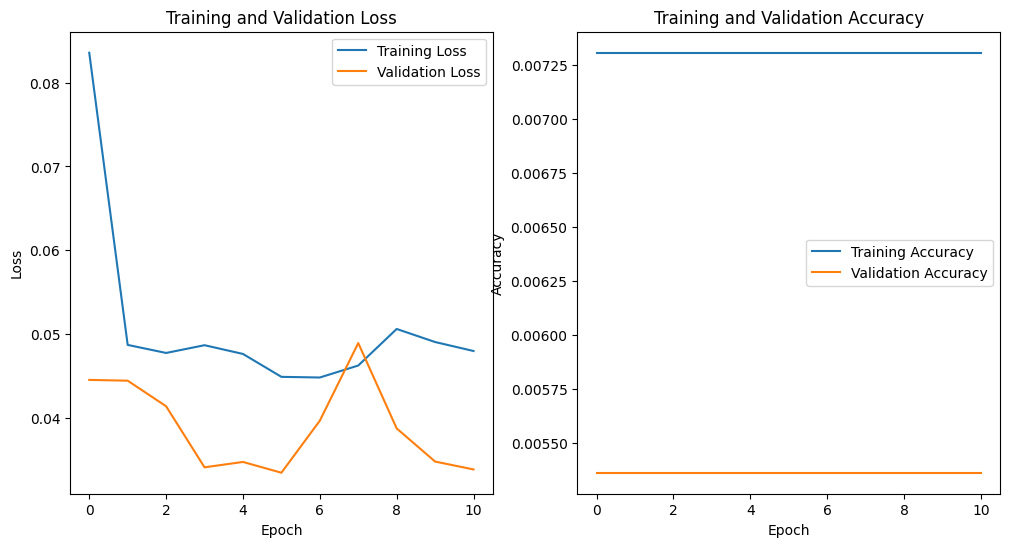

47/47 [==============================] - 131s 3s/step - loss: 0.0323 - accuracy: 0.0052
Test Loss: 0.03228113427758217
Test Accuracy: 0.005202354397624731


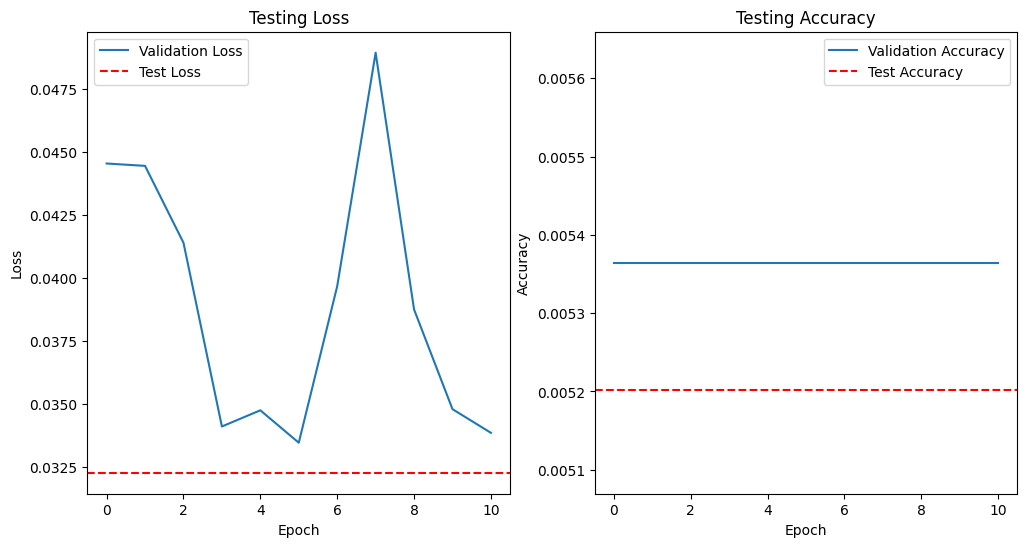

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/corrosion'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 582s 4s/step - loss: 0.4260 - accuracy: 0.1139 - val_loss: 0.3425 - val_accuracy: 0.1073
Epoch 2/25
141/141 [==============================] - 61s 432ms/step - loss: 0.3653 - accuracy: 0.1139 - val_loss: 0.3461 - val_accuracy: 0.1073
Epoch 3/25
141/141 [==============================] - 60s 425ms/step - loss: 0.3583 - accuracy: 0.1139 - val_loss: 0.3460 - val_accuracy: 0.1073
Epoch 4/25
141/141 [==============================] - 61s 431ms/step - loss: 0.3585 - accuracy: 0.1139 - val_loss: 0.3413 - val_accuracy: 0.1073
Epoch 5/25
141/141 [==============================] - 60s 424ms/step - loss: 0.3588 - accuracy: 0.1139 - val_loss: 0.3504 - val_accuracy: 0.1073
Epoch 6/25
141/141 [==============================] - 58s 412ms/step - loss: 0.3596 - accuracy: 

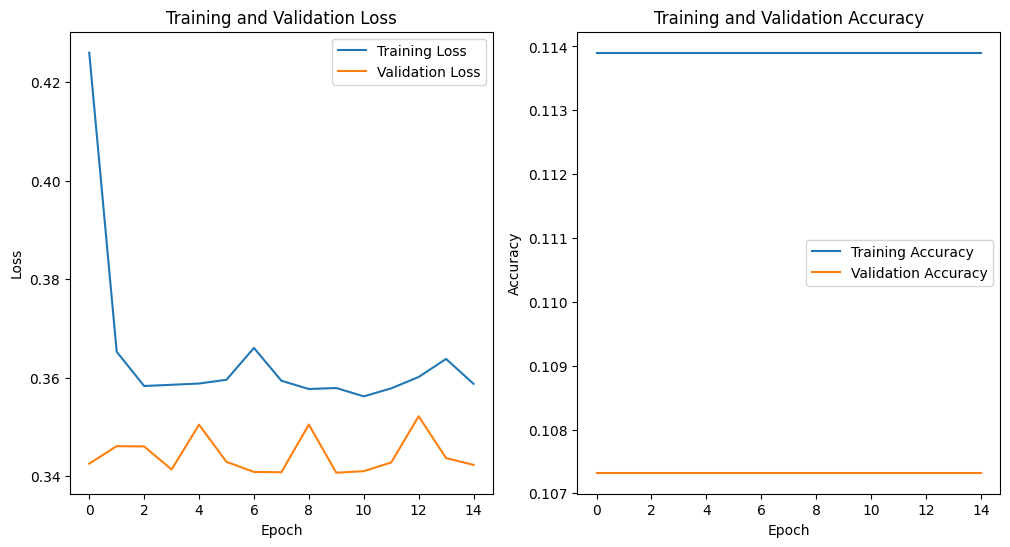

47/47 [==============================] - 128s 3s/step - loss: 0.2901 - accuracy: 0.0842
Test Loss: 0.2901281714439392
Test Accuracy: 0.08418164402246475


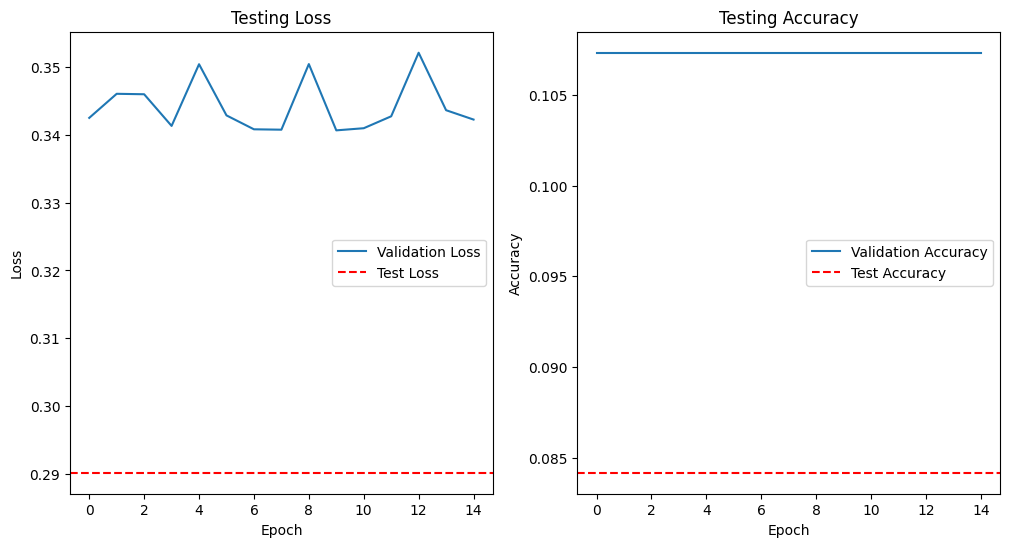

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/sea_chest_grating'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 547s 4s/step - loss: 0.0694 - accuracy: 0.0065 - val_loss: 0.0383 - val_accuracy: 0.0060
Epoch 2/25
141/141 [==============================] - 61s 432ms/step - loss: 0.0498 - accuracy: 0.0065 - val_loss: 0.0378 - val_accuracy: 0.0060
Epoch 3/25
141/141 [==============================] - 60s 427ms/step - loss: 0.0456 - accuracy: 0.0065 - val_loss: 0.0414 - val_accuracy: 0.0060
Epoch 4/25
141/141 [==============================] - 61s 429ms/step - loss: 0.0444 - accuracy: 0.0065 - val_loss: 0.0375 - val_accuracy: 0.0060
Epoch 5/25
141/141 [==============================] - 60s 425ms/step - loss: 0.0444 - accuracy: 0.0065 - val_loss: 0.0395 - val_accuracy: 0.0060
Epoch 6/25
141/141 [==============================] - 60s 427ms/step - loss: 0.0392 - accuracy: 

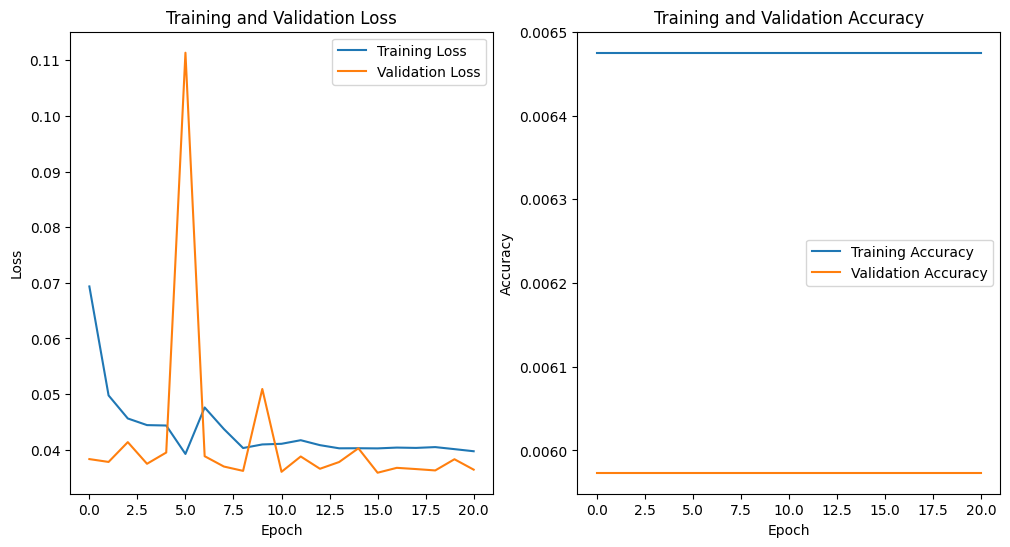

47/47 [==============================] - 131s 3s/step - loss: 0.0391 - accuracy: 0.0064
Test Loss: 0.039138324558734894
Test Accuracy: 0.006435840856283903


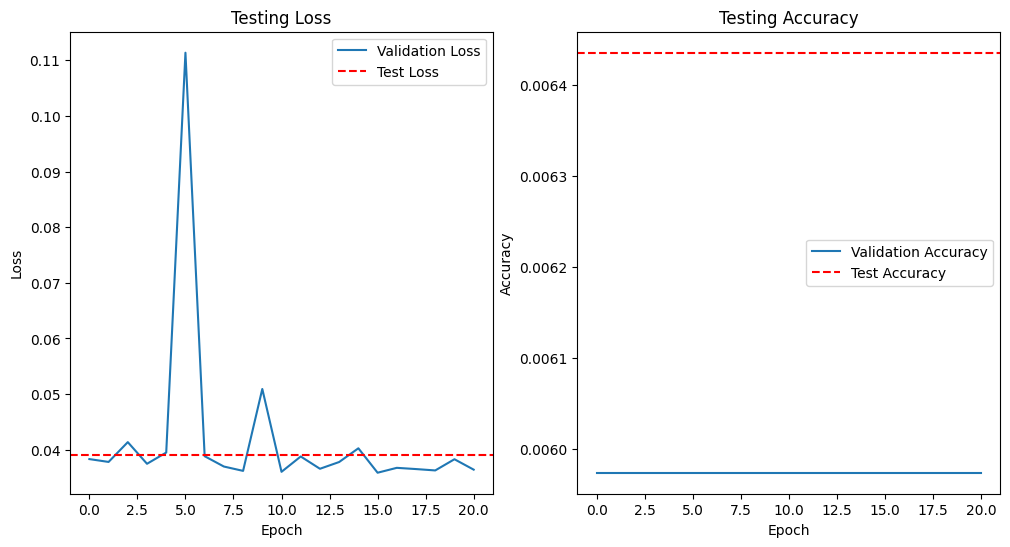

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/over_board_valves'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 574s 4s/step - loss: 0.0541 - accuracy: 0.0054 - val_loss: 0.0383 - val_accuracy: 0.0051
Epoch 2/25
141/141 [==============================] - 70s 496ms/step - loss: 0.0457 - accuracy: 0.0054 - val_loss: 0.0327 - val_accuracy: 0.0051
Epoch 3/25
141/141 [==============================] - 61s 428ms/step - loss: 0.0429 - accuracy: 0.0054 - val_loss: 0.0339 - val_accuracy: 0.0051
Epoch 4/25
141/141 [==============================] - 69s 490ms/step - loss: 0.0371 - accuracy: 0.0054 - val_loss: 0.0340 - val_accuracy: 0.0051
Epoch 5/25
141/141 [==============================] - 69s 492ms/step - loss: 0.0364 - accuracy: 0.0054 - val_loss: 0.0331 - val_accuracy: 0.0051
Epoch 6/25
141/141 [==============================] - 61s 428ms/step - loss: 0.0369 - accuracy: 

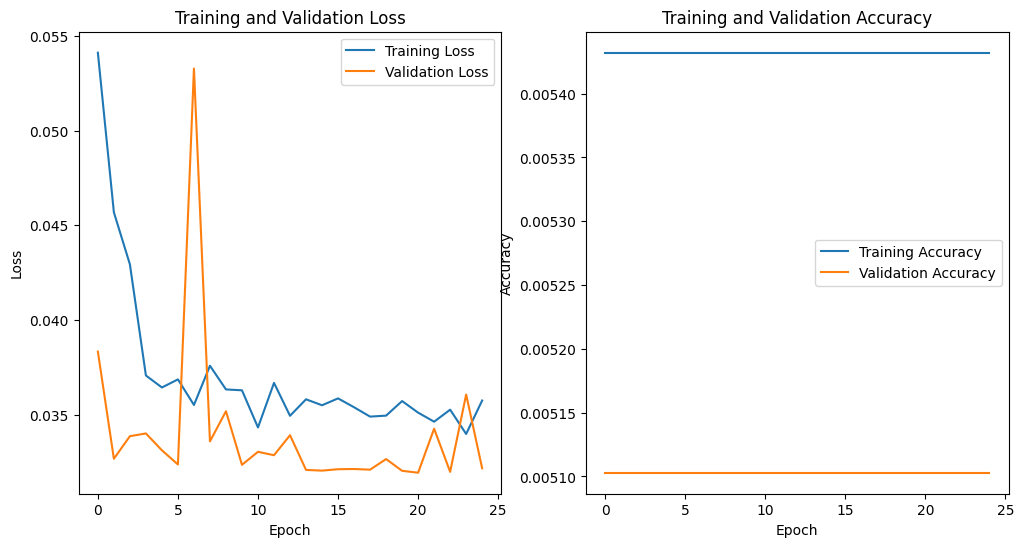

47/47 [==============================] - 127s 3s/step - loss: 0.0284 - accuracy: 0.0044
Test Loss: 0.028407925739884377
Test Accuracy: 0.004413239657878876


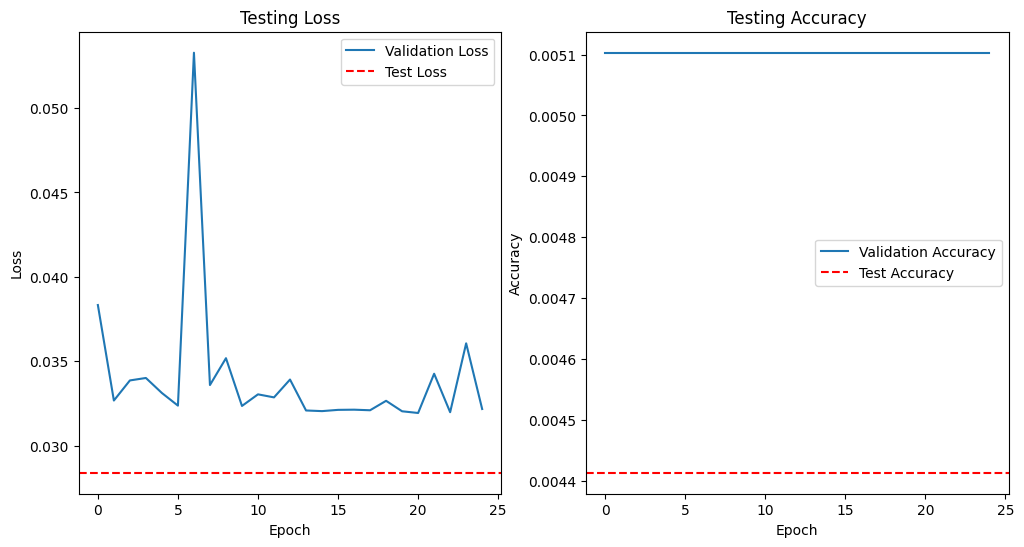

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/anode'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/bilge_keel'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



Mounted at /content/drive
1893 1893
Found 1893 images.
Found 1893 mask files.
Epoch 1/25
141/141 [==============================] - 6301s 45s/step - loss: 0.1816 - accuracy: 0.0198 - val_loss: 0.0967 - val_accuracy: 0.0173
Epoch 2/25
 20/141 [===>..........................] - ETA: 1:19:24 - loss: 0.1088 - accuracy: 0.0191

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/defect'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/LIACI/images'
masks_path = '/content/drive/MyDrive/LIACI/ship_hull'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = [f for f in os.listdir(masks_path) if f.endswith('.bmp')]

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Ensure channel dimension is added

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            x[i], y[i] = adjust_data(img, mask)


        return x, y

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # (Additional encoding layers would go here)
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)  # Example bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    merge1 = concatenate([conv1, up1], axis=3)  # Adjusted to concatenate with the correct layer
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # (Additional decoding layers would mirror the encoding layers)
    # Output layer
    output = Conv2D(1, 1, activation='softmax')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks= [early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

